# Run every time

In [1]:
# Author: Vivian Wong
# Modified from Code by Sherlock Liao available at https://github.com/L1aoXingyu/pytorch-beginner?files=1

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from torchsummary import summary
import pandas as pd
from tqdm.auto import tqdm
import json

In [2]:
IMG_SIZE = 56
model_path = './unet_56crop.pth'
BATCH_SIZE = 512 #
num_epochs = 30
learning_rate = 1e-3
FIG_SIZE = (40,40)

In [3]:
def load_meltpool_dataset():
    # 56x56. modify CNN to match when loading
    root = './data/meltpool/Meltpool_Camera_(partial)_processed'
    batch_size = BATCH_SIZE
    
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset, dataloader

def load_MNIST_dataset():
    # 28x28. modify CNN to match when loading.
    batch_size = BATCH_SIZE
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = MNIST('./data', transform=transform, download=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset, dataloader

In [4]:
# simple convolutional autoencoder
class simple_autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        # for 28x28
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
#             nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
#             nn.Tanh()
#         )
        # for 56x56
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 6, stride=6, padding=2),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=4, padding=2),  # b, 1, 56, 56
            nn.Tanh()
        )
        # for 100x100
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 6, stride=2, padding=2),  # b, 16, 50, 50
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=2),  # b, 16, 25, 25
#             nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 13, 13
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1),  # b, 8, 12, 12
#             nn.Conv2d(8, 4, 3, stride=3, padding=0),  # b, 8, 4, 4
#             nn.ReLU(True),
#             nn.MaxPool2d(2, stride=1)  # b, 8, 3, 3
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(4, 8, 3, stride=1),  # b, 8, 5, 5
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 16, 5, stride=1, padding=0),  # b, 16, 9, 9
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 8, 3, stride=4, padding=0),  # b, 8, 35, 35
#             nn.ReLU(True),
#             nn.ConvTranspose2d(8, 1, 4, stride=3, padding=3),  # b, 8, 100, 100
#             nn.Tanh()
#         )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
# UNET
import torch.nn.functional as F

from unet_parts import *


class autoencoder(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=True):
        super(autoencoder, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x) # b, 64, 56, 56
        x2 = self.down1(x1) # 28, 28
        x3 = self.down2(x2) # 14, 14
        x4 = self.down3(x3) # 7, 7
        encoded = self.down4(x4) # 3,3
        x = self.up1(encoded, x4) # 7,7
        x = self.up2(x, x3) # 14,14
        x = self.up3(x, x2) # 28,28
        x = self.up4(x, x1) # 56,56
        decoded = self.outc(x) # 56,56
        return encoded, decoded

In [6]:
if not os.path.exists('./conv_img'):
    os.mkdir('./conv_img')
    
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, IMG_SIZE, IMG_SIZE)
    return x

using device: cuda


In [7]:
dataset, dataloader = load_meltpool_dataset()
# dataset, dataloader = load_MNIST_dataset()
dataset

Dataset ImageFolder
    Number of datapoints: 59948
    Root location: ./data/meltpool/Meltpool_Camera_(partial)_processed
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               CenterCrop(size=(56, 56))
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [8]:
def plot2D_with_labels(XY, labels, num_labels=9):
    if type(XY)==torch.Tensor:
        XY = XY.numpy()
    plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / num_labels)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)

In [9]:
def plot3D_with_labels(XYZ, labels, num_labels=9):
    if type(XYZ)==torch.Tensor:
        XYZ = XYZ.numpy()
    fig = plt.figure(2); ax = Axes3D(fig)
    X, Y, Z = XYZ[:, 0].numpy(), XYZ[:, 1].numpy(), XYZ[:, 2].numpy() # put encoded data to [x,y,z]
    digits = train_data.train_labels[:200].numpy()
    for x, y, z, s in zip(X, Y, Z, digits):
        c = cm.rainbow(int(255*s/num_labels)); ax.text(x, y, z, s, backgroundcolor=c)
    ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
    plt.show()

In [10]:
def plot2D_with_thumbnails(XY, labels, thumbnails, num_labels = 9, cmap = None, plot_colormap = True):
    def getThumbnail(path):
        return OffsetImage(plt.imread(path), zoom=0.5, cmap=cmap)

    if type(XY)==torch.Tensor:
        XY = XY.numpy()
#     plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    
    if plot_colormap: 
        rgbs = np.zeros((FIG_SIZE[0],FIG_SIZE[1],3))
        rgbs[:,:,2] += 0.5 # blue channel always 0.5
        rgbs[:,:,1] += np.tile(np.linspace(0, 1, num=FIG_SIZE[0]),(FIG_SIZE[1],1)).T# green channel is vertical axis
        rgbs[:,:,0] += np.tile(np.linspace(1, 0, num=FIG_SIZE[1]),(FIG_SIZE[0],1))# red channel is horizontal axis 
        ax.imshow(rgbs,extent=(1,0,1,0))
        ax.set_xlabel('Red')
        ax.set_ylabel('Green')
        ax.set_title('Blue=0.5')
        X = 1-X # to preserve cluster shape on inverted graph axis 
        Y = 1-Y
            
    ax.scatter(X, Y) 
    for x, y, s, path in zip(X, Y, labels, thumbnails):
        ab = AnnotationBbox(getThumbnail(path), (x, y), frameon=True)
        ax.add_artist(ab)
    
    return fig
#         c = cm.rainbow(int(255 * s / num_labels))
#         plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#         plt.scatter(x, y, marker=path)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)
    
def plot_heatmap(X_embedded, xs, ys): 
    X_embedded=1-X_embedded # since x_embedded axis are inverted w.r.t. rgb axis
    print(X_embedded.shape)
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    if X_embedded.shape[1] == 3:
        rgbs = X_embedded
    elif X_embedded.shape[1]==2:
        rgbs = np.concatenate((X_embedded,0.5*np.ones((X_embedded.shape[0],1))),axis=1) # R,G = X_embedded, B = 0.5, 
    else:
        print('ERROR in X_embedded dim')
#     colors = [(X_embedded[i,0], X_embedded[i,1],X_embedded[i,2]) for i in range(0, len(xs))]
#     print(colors)
#     plt.imshow(m, cmap=cm.hot)
#     plt.colorbar()
#     plt.show()
    ax.scatter(xs,ys,s=500,c=rgbs)
#     ax.scatter(xs[5],ys[5],marker='*',s=1000)
    return fig

# Train

In [67]:
# train autoencoder
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
#         img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        # ===================forward=====================
        encoded, decoded = model(img)
        loss = criterion(decoded, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(decoded.cpu().data)
        save_image(pic, './conv_img/image_{}.png'.format(epoch))
        torch.save(model.state_dict(), model_path)

epoch [1/30], loss:0.0002
epoch [2/30], loss:0.0002
epoch [3/30], loss:0.0002
epoch [4/30], loss:0.0001
epoch [5/30], loss:0.0001
epoch [6/30], loss:0.0005
epoch [7/30], loss:0.0001
epoch [8/30], loss:0.0002
epoch [9/30], loss:0.0002
epoch [10/30], loss:0.0002
epoch [11/30], loss:0.0001
epoch [12/30], loss:0.0001
epoch [13/30], loss:0.0003
epoch [14/30], loss:0.0003
epoch [15/30], loss:0.0002
epoch [16/30], loss:0.0001
epoch [17/30], loss:0.0002
epoch [18/30], loss:0.0000
epoch [19/30], loss:0.0001
epoch [20/30], loss:0.0001
epoch [21/30], loss:0.0000
epoch [22/30], loss:0.0001
epoch [23/30], loss:0.0002
epoch [24/30], loss:0.0002
epoch [25/30], loss:0.0001
epoch [26/30], loss:0.0001
epoch [27/30], loss:0.0000
epoch [28/30], loss:0.0001
epoch [29/30], loss:0.0001
epoch [30/30], loss:0.0002


In [69]:
torch.save(model.state_dict(), model_path)

## View encoder output in 2D

In [11]:
# load model state dict
device = torch.device('cpu')
model = autoencoder().to(device)
model.load_state_dict(torch.load(model_path,map_location=device))

model.eval()

autoencoder(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05,

In [15]:
summary(model, input_size=(1,IMG_SIZE,IMG_SIZE), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]             640
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,928
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
        DoubleConv-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 28, 28]               0
            Conv2d-9          [-1, 128, 28, 28]          73,856
      BatchNorm2d-10          [-1, 128, 28, 28]             256
             ReLU-11          [-1, 128, 28, 28]               0
           Conv2d-12          [-1, 128, 28, 28]         147,584
      BatchNorm2d-13          [-1, 128, 28, 28]             256
             ReLU-14          [-1, 128,

### Meltpool

In [12]:
num_viewed = 3560 # max our EIL machine can do on CPU is 3000
random_seed = 1
xs = []
ys = []
indices = list(range(len(dataset)))
np.random.seed(random_seed)
np.random.shuffle(indices)
view_indices = indices[:num_viewed]
    # plot layer 202 images only. num_viewed=2911
# view_indices = list(range(18642,18642+num_viewed))

    # plot layer 203 images only. num_viewed=3560
view_indices = list(range(18642+2911,18642+2911+num_viewed))

# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 1, IMG_SIZE, IMG_SIZE)
view_data_layers = np.random.randint(1, size=num_viewed)

view_thumbnails = [dataset.imgs[i][0] for i in view_indices]
view_thumbnails_original = []
for path in view_thumbnails:
    view_thumbnails_original += [path.replace("Meltpool_Camera_(partial)_processed","Meltpool_Camera_(partial)")]

with open('xypt.json') as jsonfile:
    xypt = json.load(jsonfile)
    assert len(xypt) == len(dataset)

for i in range(num_viewed):
    view_data[i,:,:,:] = dataset[view_indices[i]][0]
    view_data_layers[i] = int(dataset[view_indices[i]][1]) # layer index (0 - 14)
    xs.append(xypt[view_indices[i]]['x'])
    ys.append(xypt[view_indices[i]]['y'])
#     img = torch.unsqueeze(torch.tensor(view_data[i,:,:,:]),0)
#     encoded_data, _ = model(img.to(device))
#     encoded_data=torch.squeeze(encoded_data,0)
#     print(encoded_data.shape)
#     if i==0:
#         all_encoded = torch.zeros([num_viewed, encoded_data.shape[0],encoded_data.shape[1],encoded_data.shape[2]])
#         print(all_encoded.shape)
#         all_encoded[0,:,:,:] = encoded_data
#     print(all_encoded.shape)
#     break
    
encoded_data, _ = model(view_data.to(device))

# # # view encoder output in 2D
# plot2D_with_labels(encoded_data.data.view(encoded_data.shape[0],-1), view_data_layers, num_labels = 15)
# plot2D_with_thumbnails(encoded_data.data.view(encoded_data.shape[0],-1), view_data_layers, view_thumbnails, num_labels = 15, cmap = 'gray')

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 2858024960 bytes. Error code 12 (Cannot allocate memory)


In [ ]:
del view_data
print(encoded_data.shape)
print(len(xs))
print(len(ys))

#### View encoder output using T-SNE

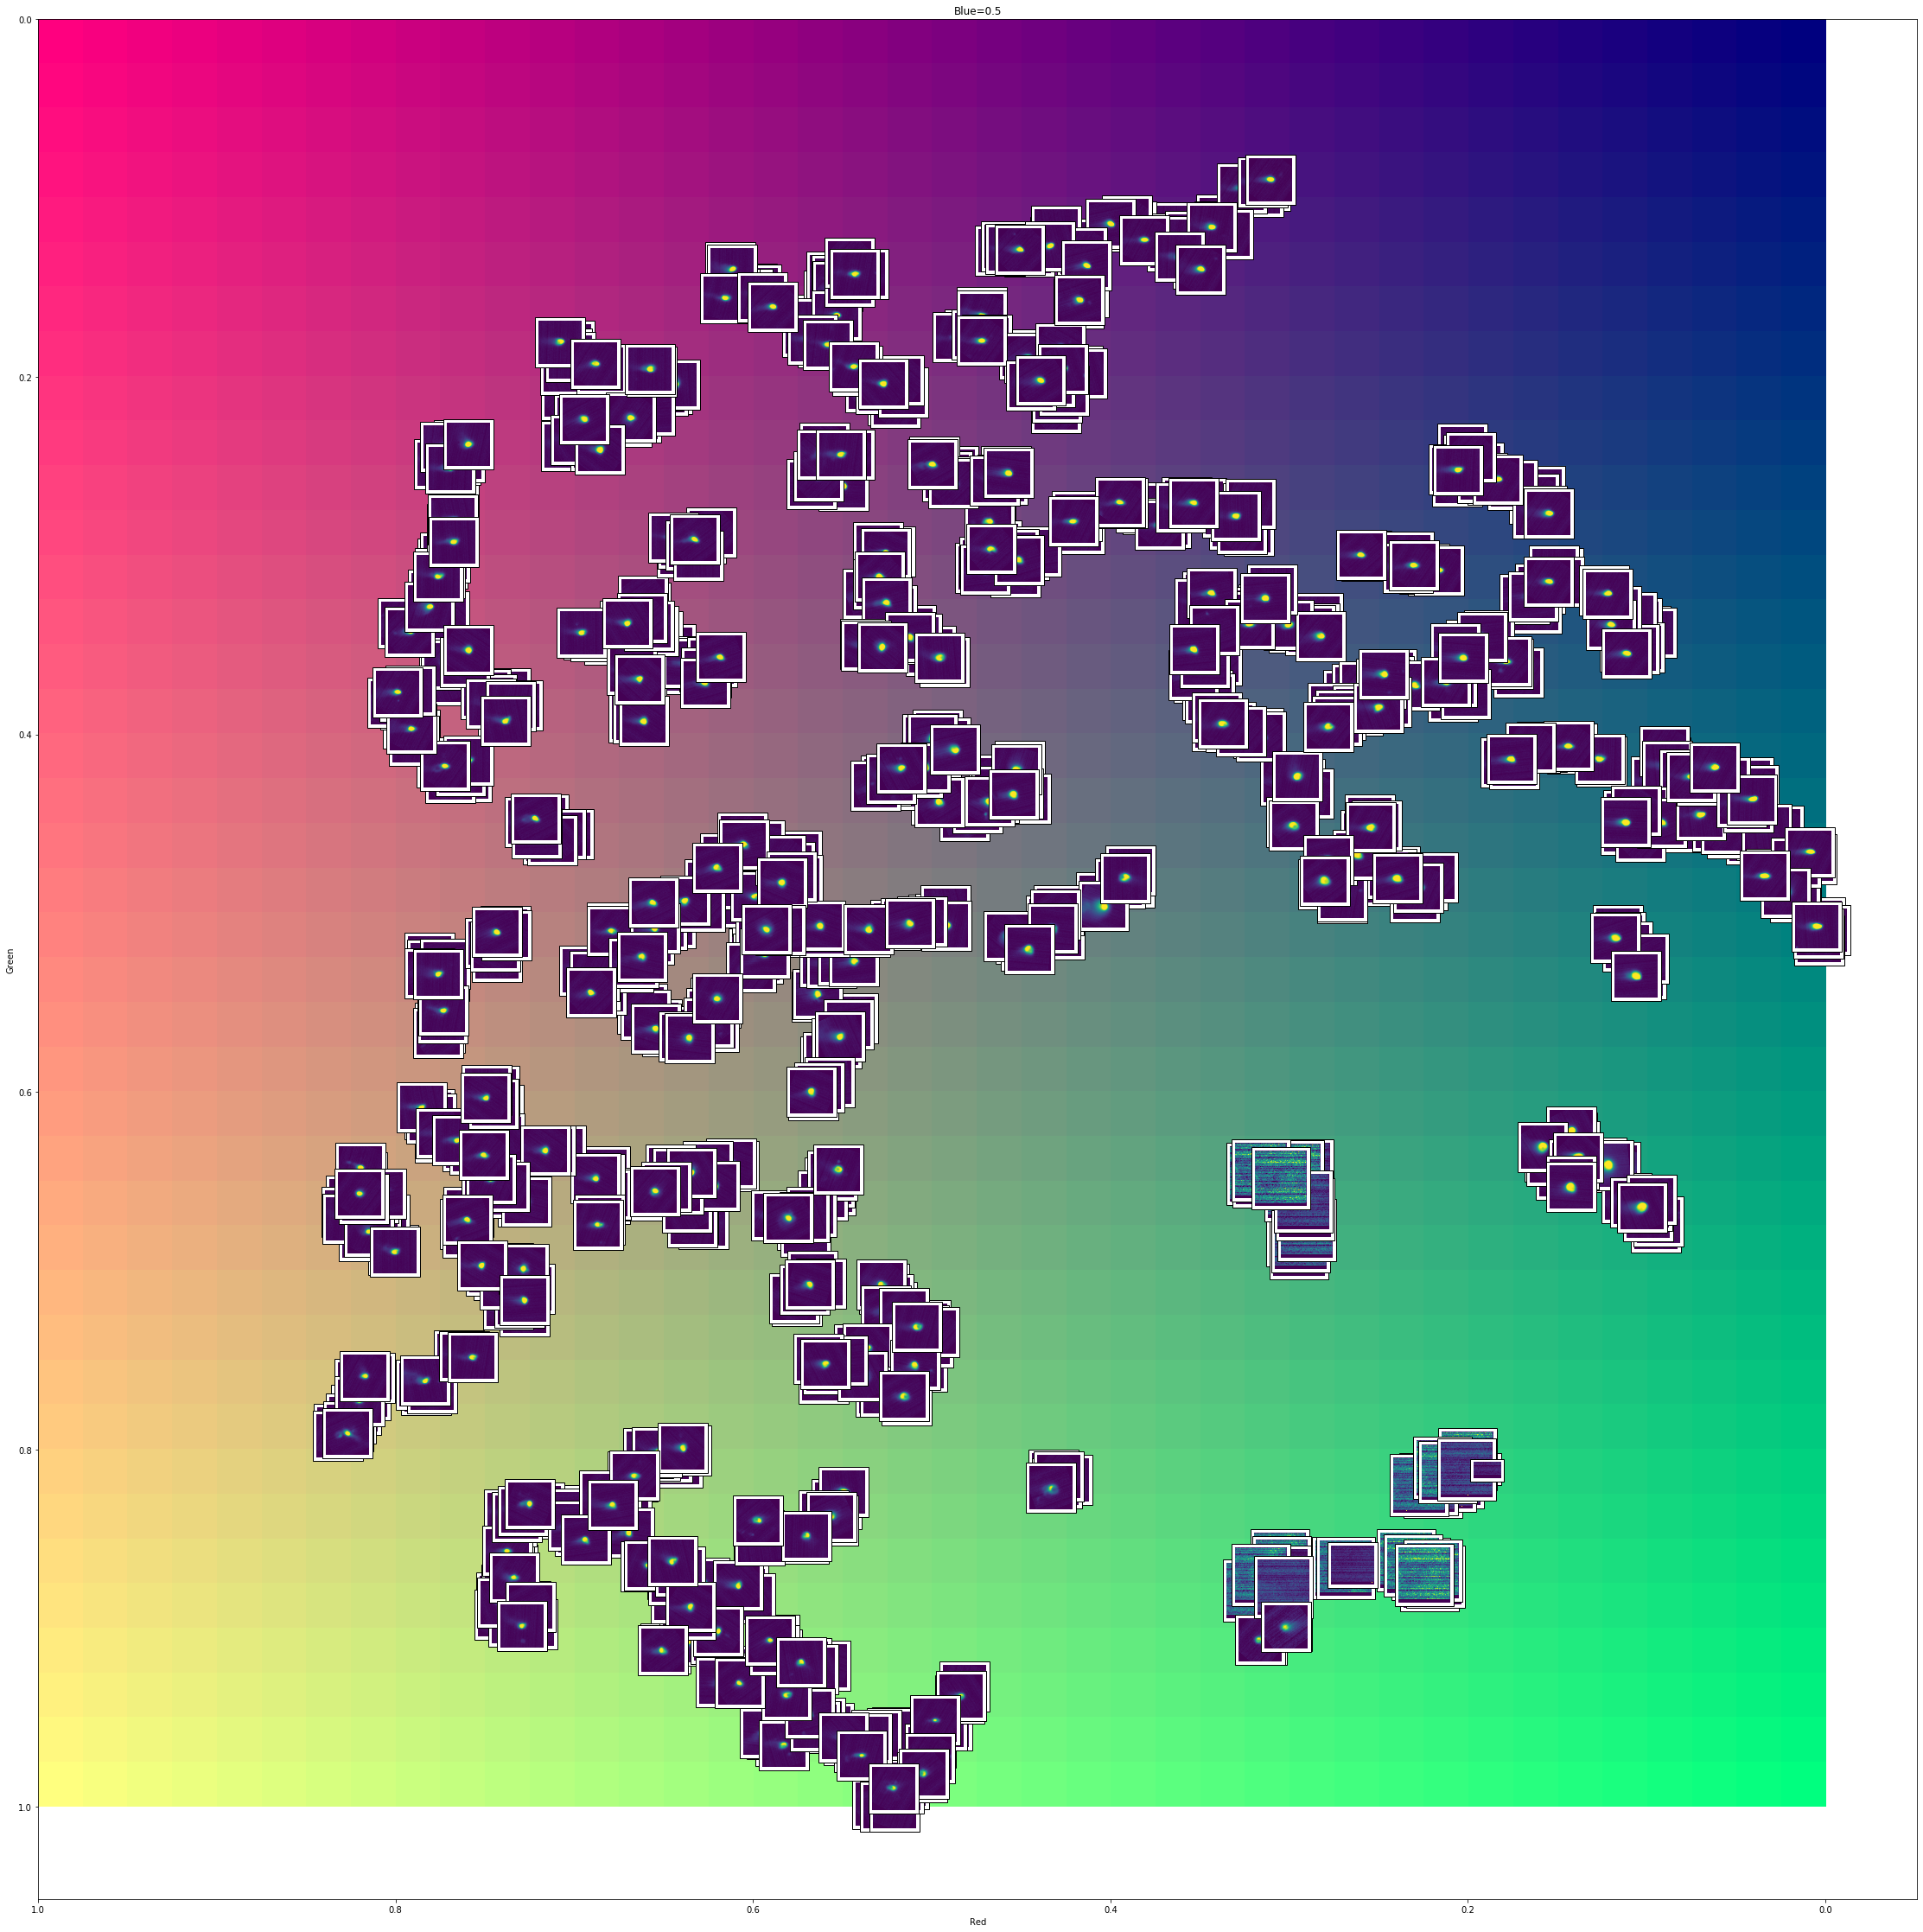

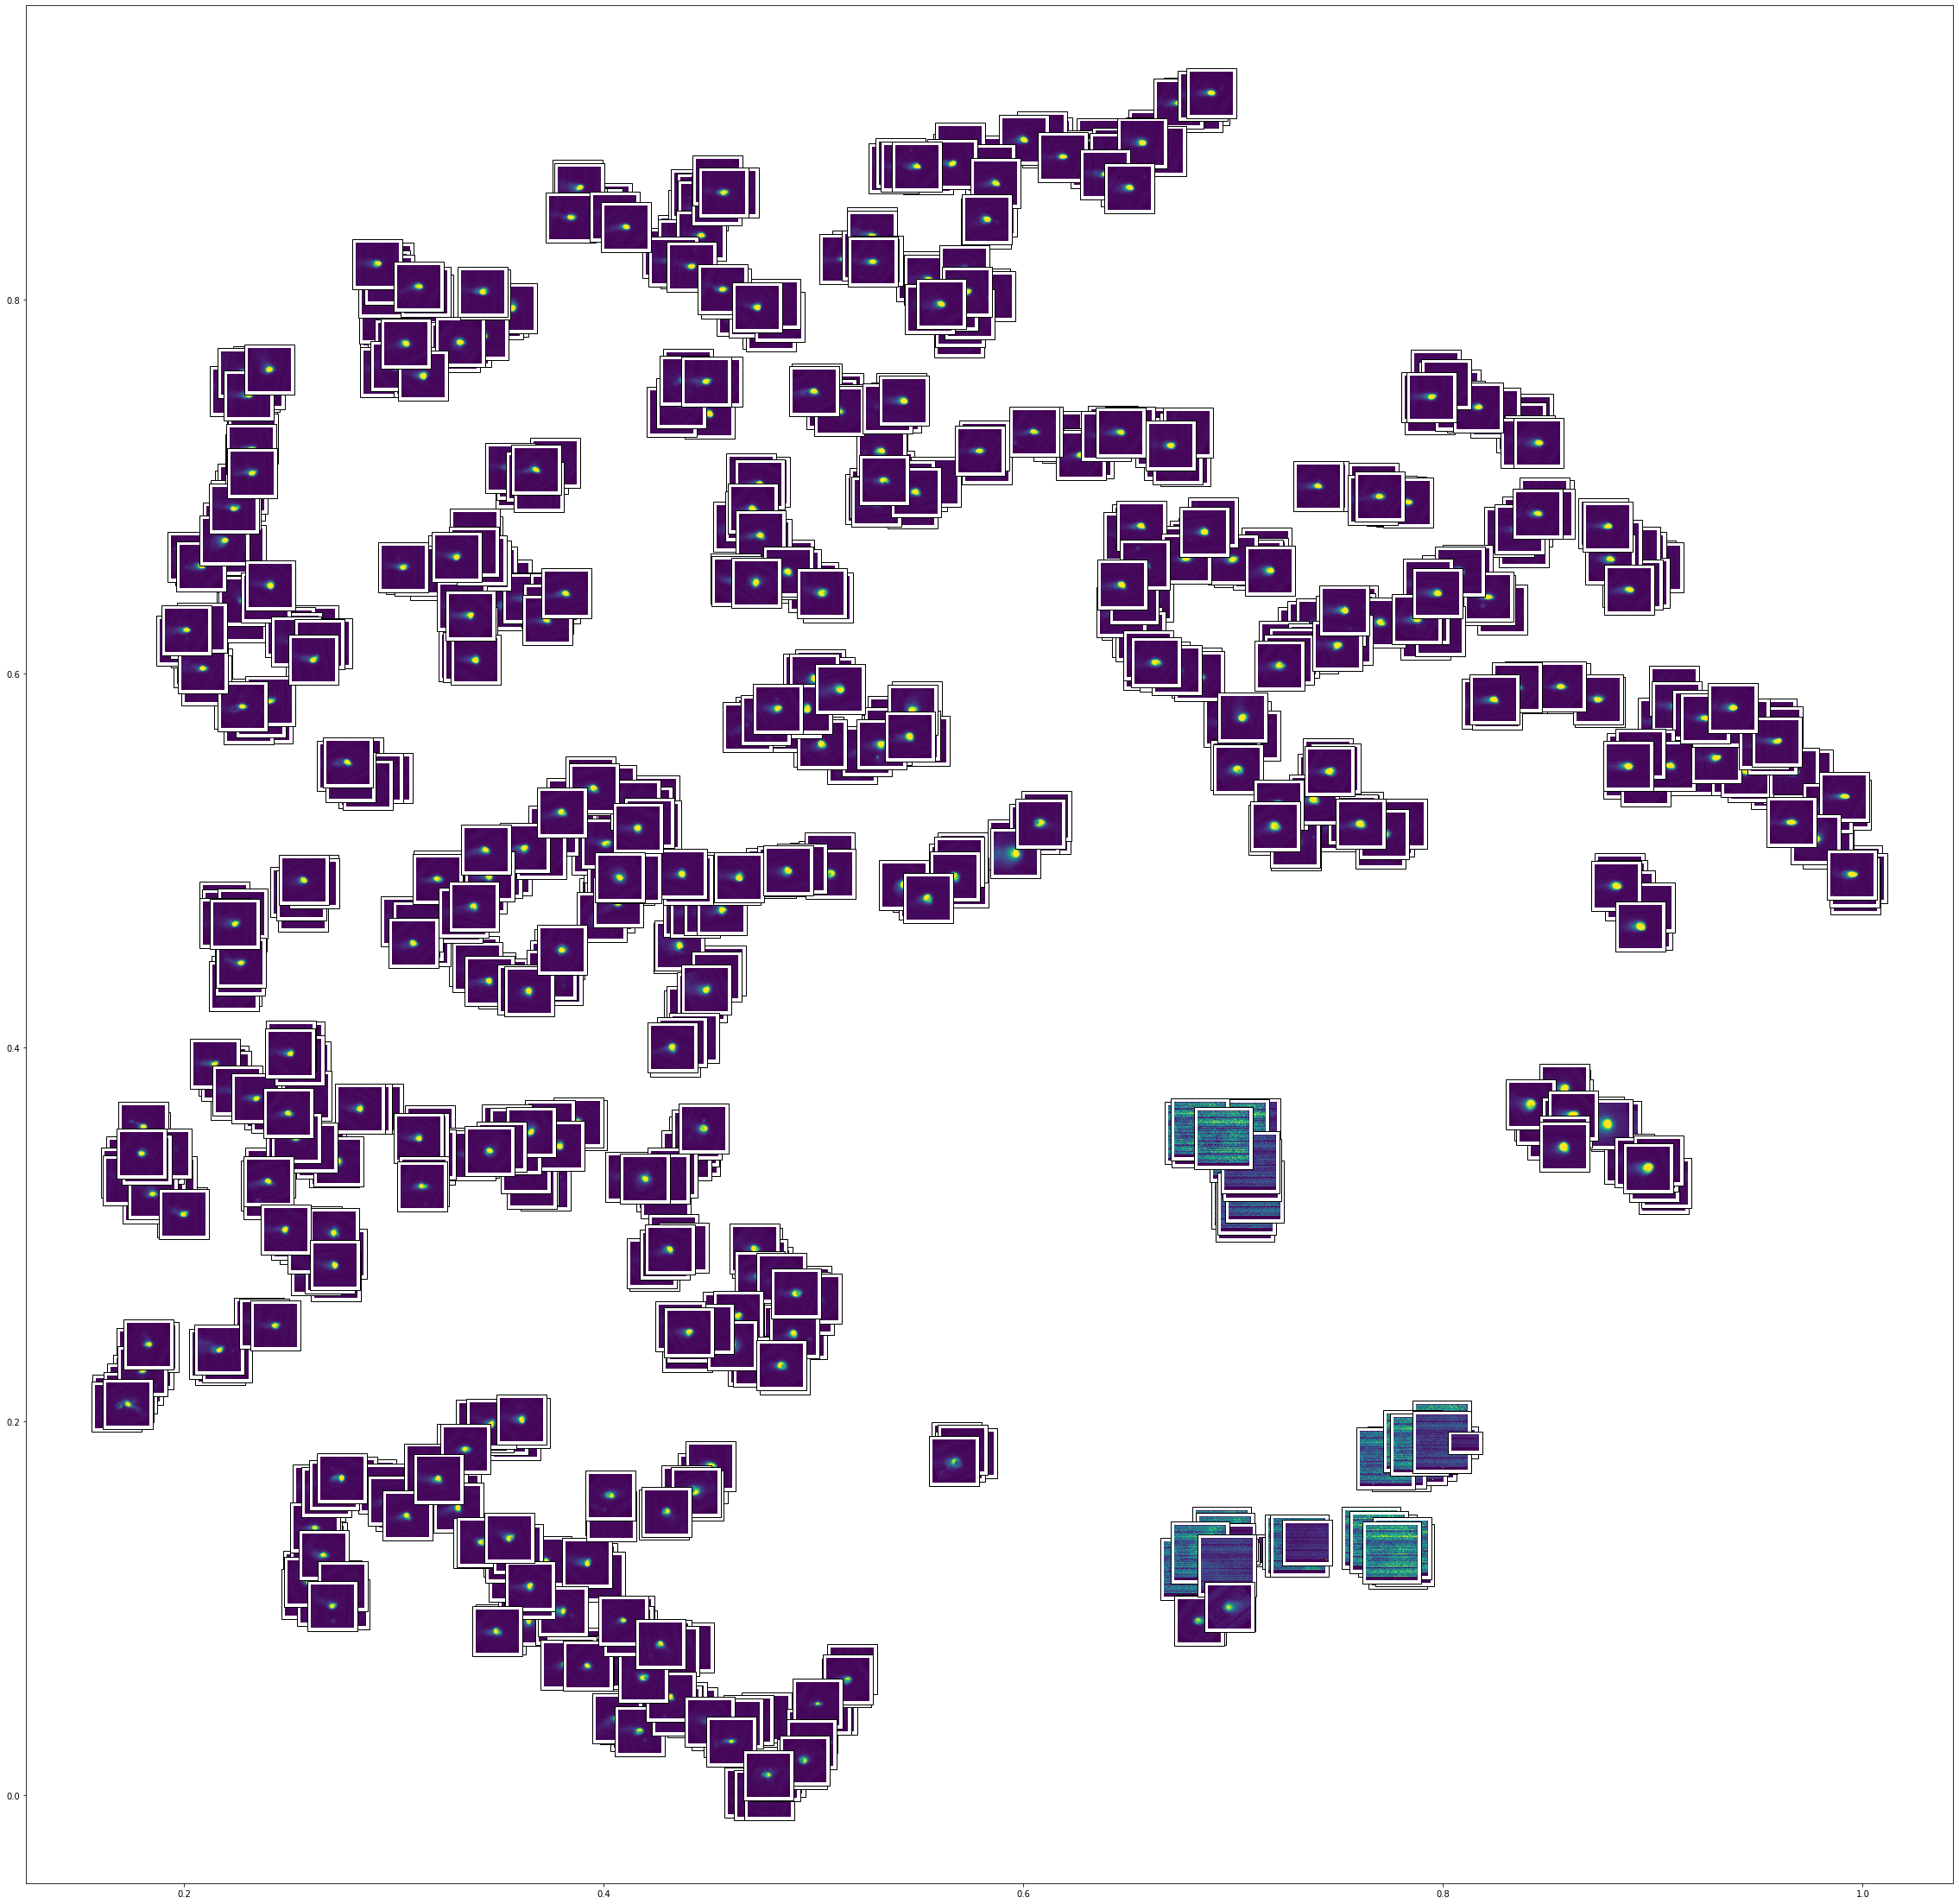

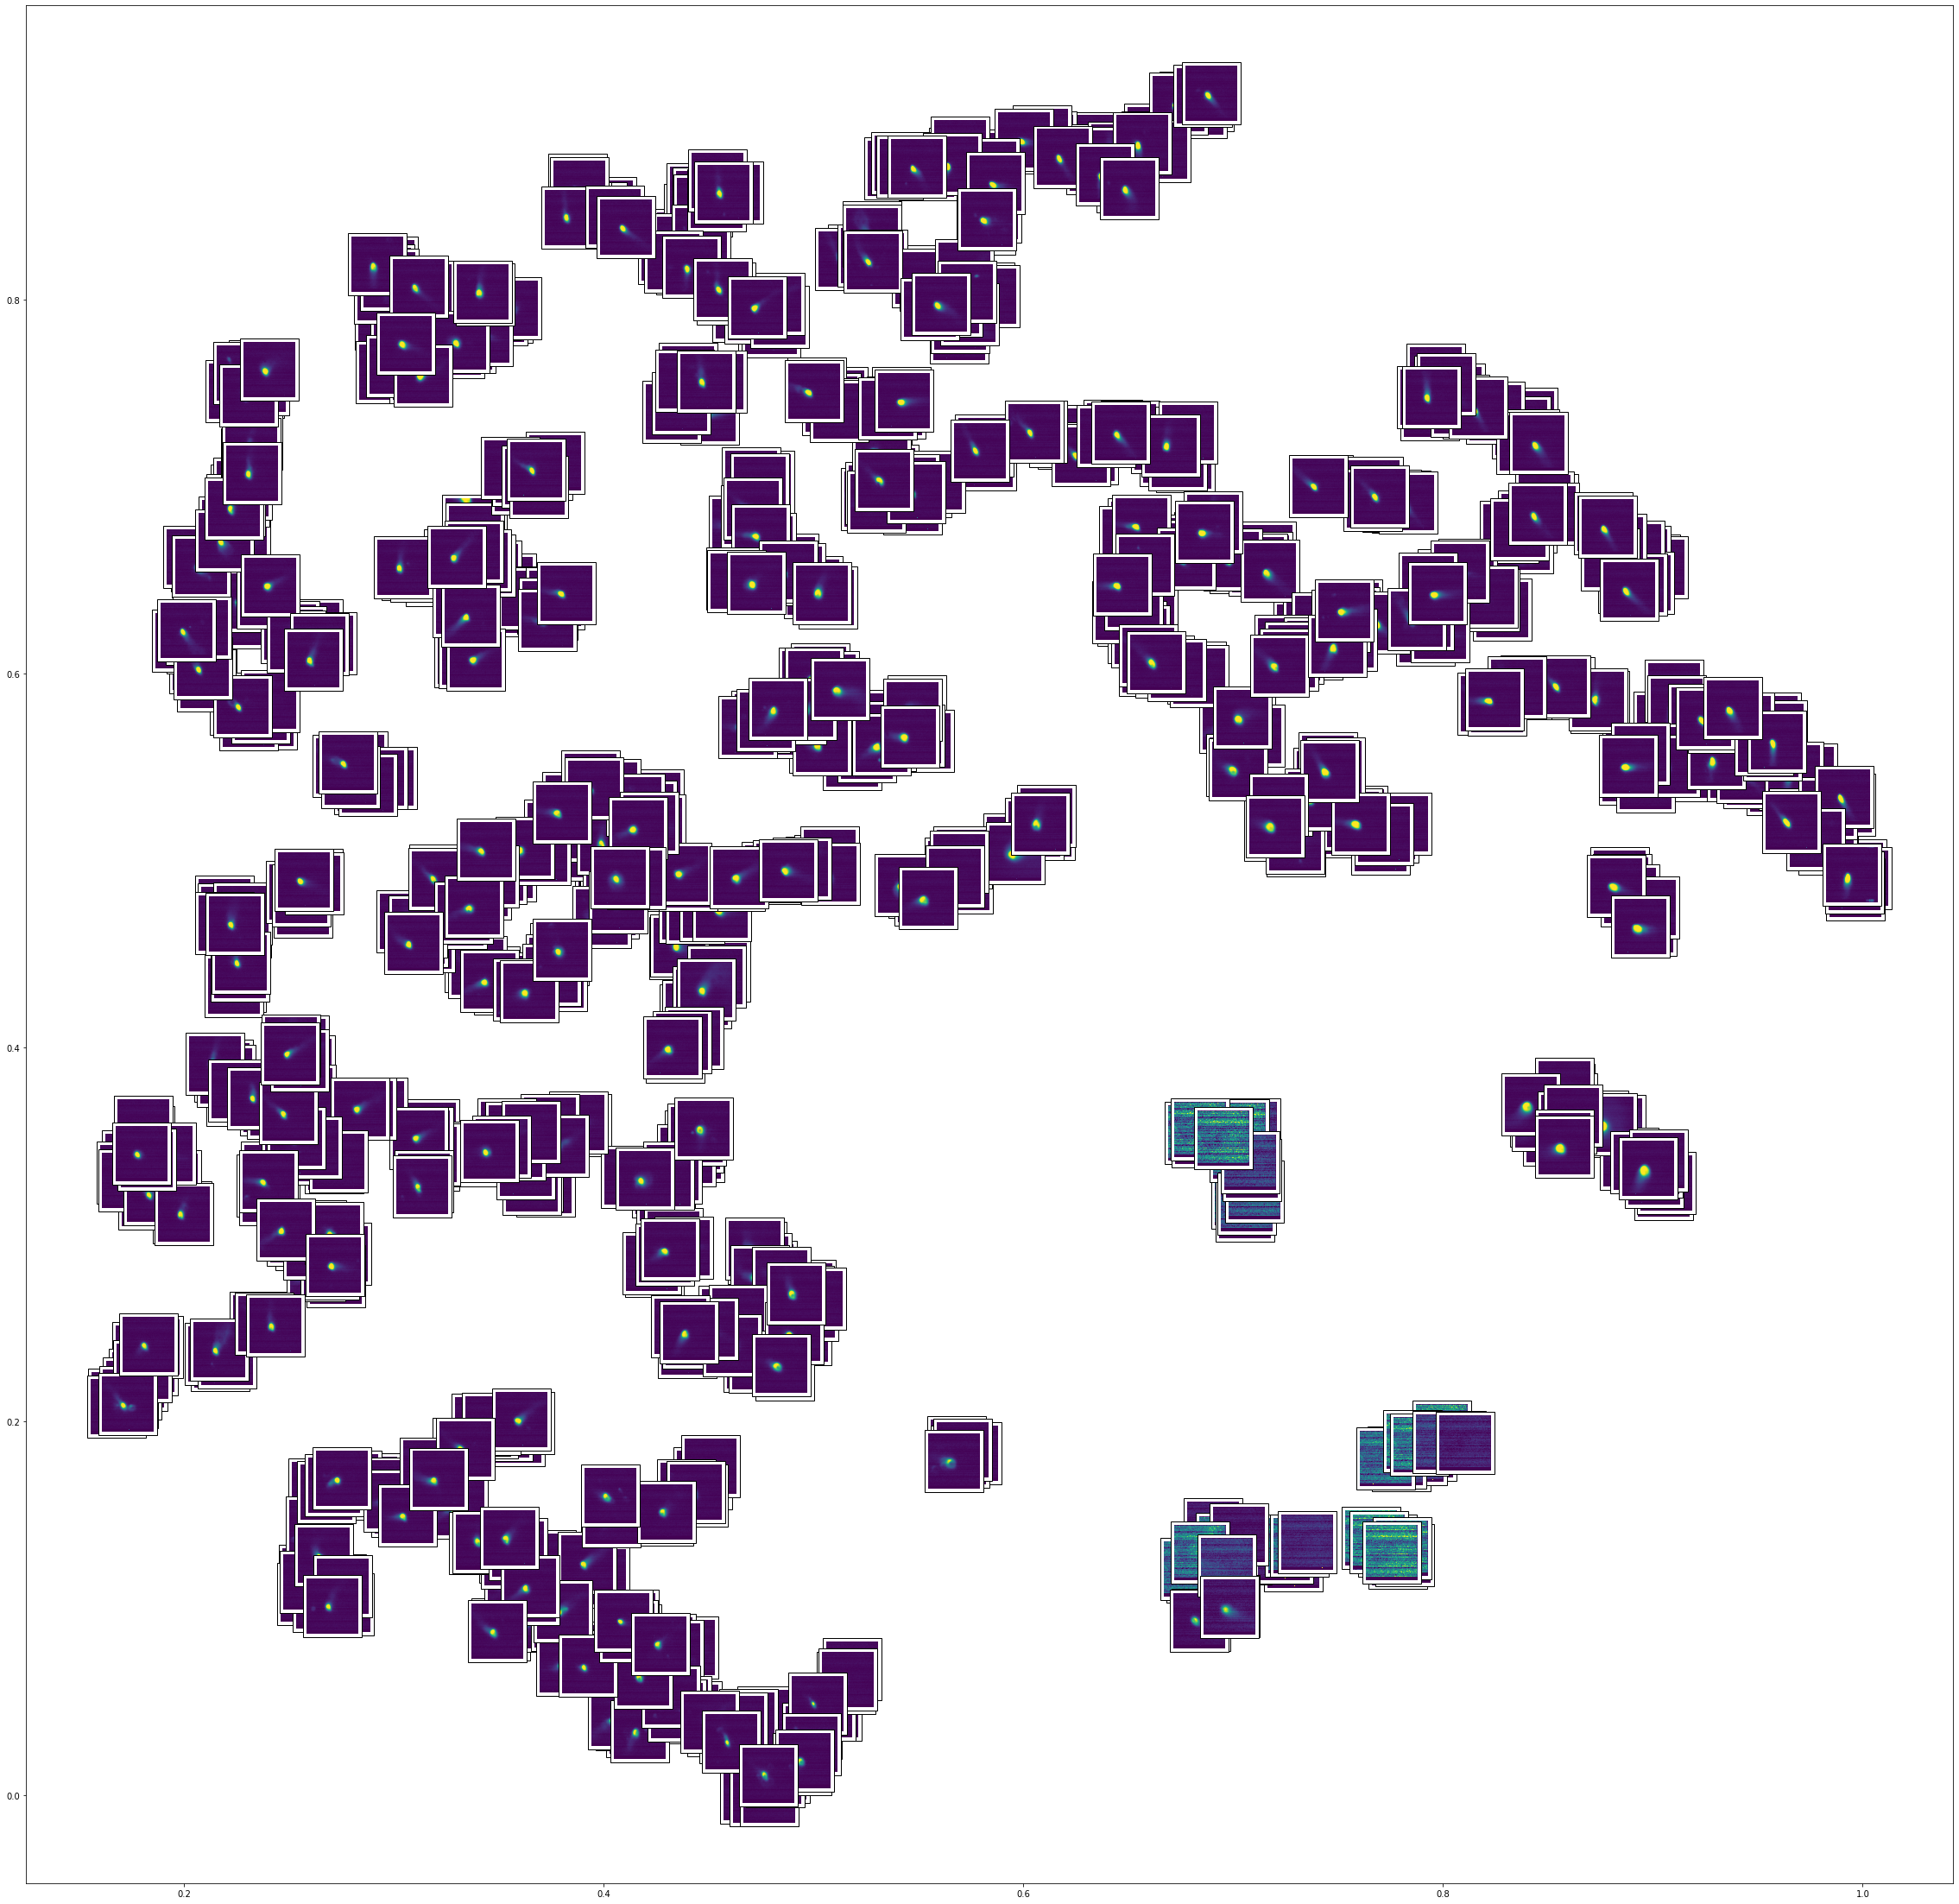

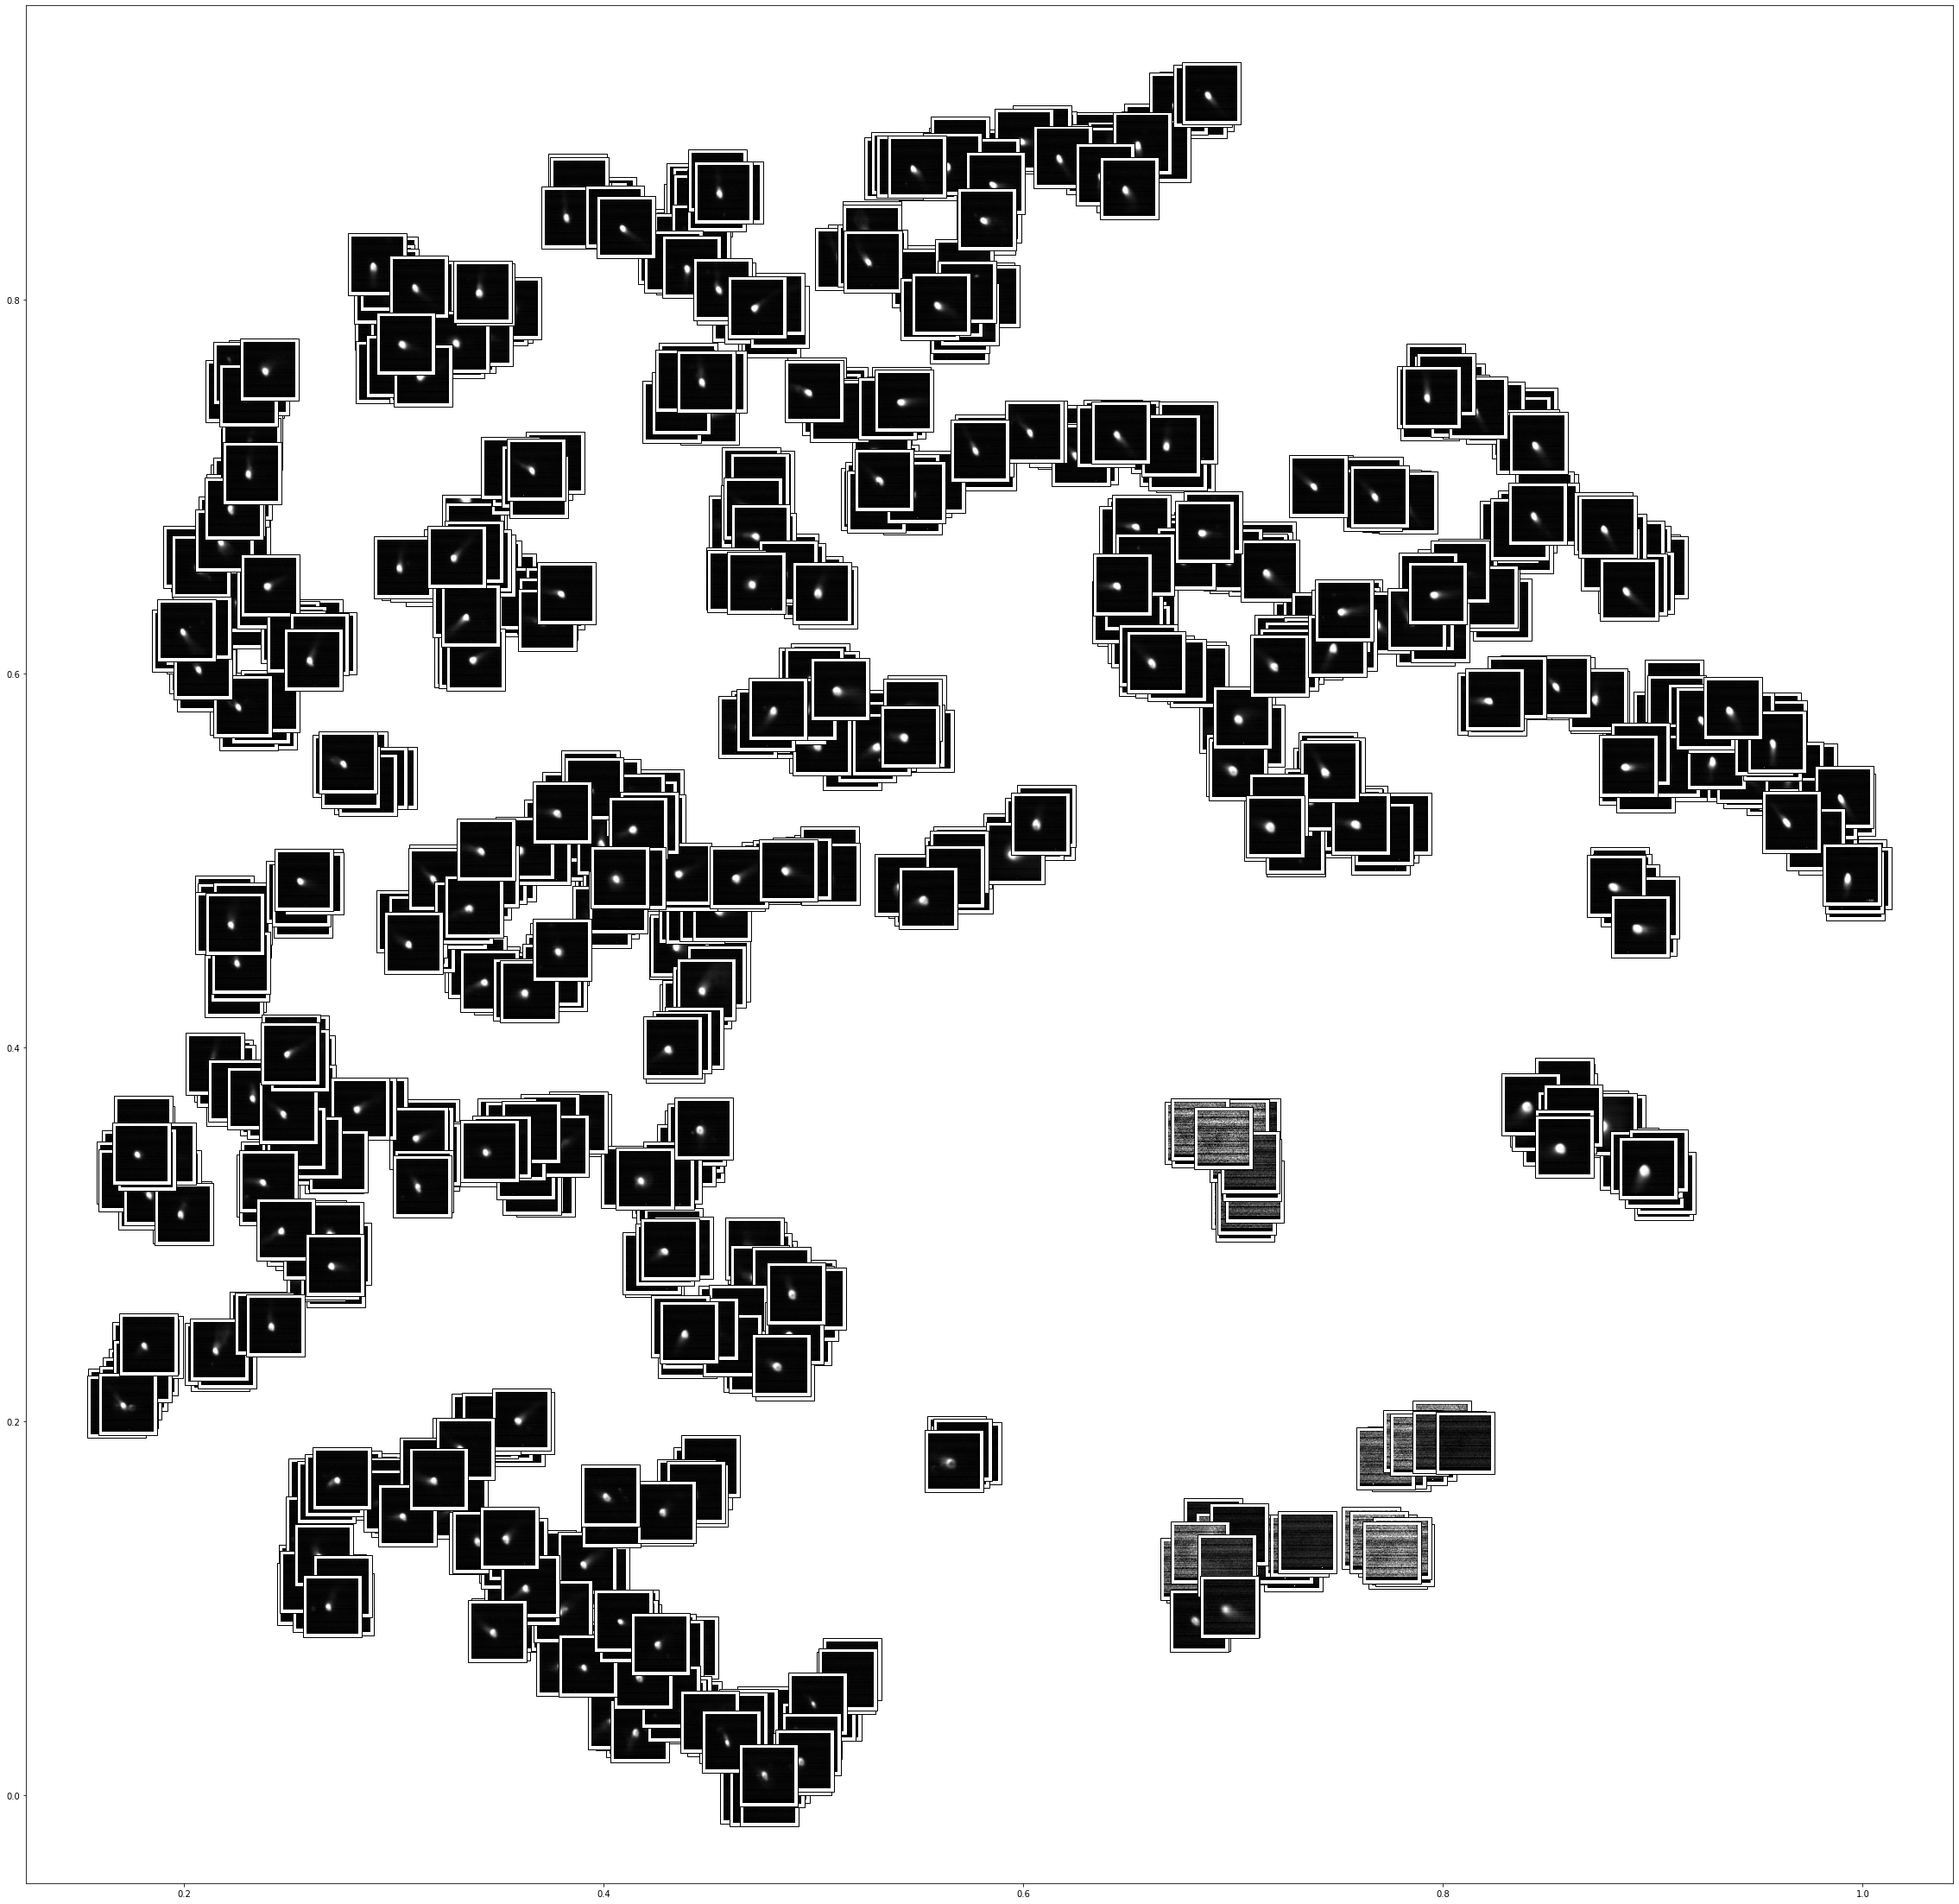

In [16]:
X = encoded_data.data.view(num_viewed,-1).numpy()
for perplexity in [5.0]:#np.linspace(5,50,num=10):
    for n_iter in [3000]:
        X_embedded = TSNE(n_components=2, perplexity=perplexity, init='pca', n_iter=n_iter).fit_transform(X)
        X_embedded = (X_embedded-np.min(X_embedded))/(np.max(X_embedded)-np.min(X_embedded)) # normalize to 0-1

        if X_embedded.shape[1] == 2: 
            # view processed images as thumbnails
            fig = plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15)
            fig.savefig('../output/unet_encoder/{}_images/perplexity{}_niter{}_withColors.png'.format(num_viewed, perplexity, n_iter))
            fig = plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15,plot_colormap=False)
            fig.savefig('../output/unet_encoder/{}_images/perplexity{}_niter{}.png'.format(num_viewed, perplexity, n_iter))

            # view unprocessed raw images as thumbnails
            fig = plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails_original, num_labels = 15,plot_colormap=False)
            fig = plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails_original, num_labels = 15,cmap='gray',plot_colormap=False)
            
        elif X_embedded.shape[1]==3: 
            print("3D CLUSTERING NOT IMPLEMENTED YET")
        else: 
            print("ERROR in X_embedded shape")

        # plot2D_with_labels(X_embedded, view_data_layers, num_labels = 15)
        
       

#### Plot heat map in XY
We plot each frame's XY from TSNE as color map and XY from XYPT file as XY axis. 

(1000, 2)


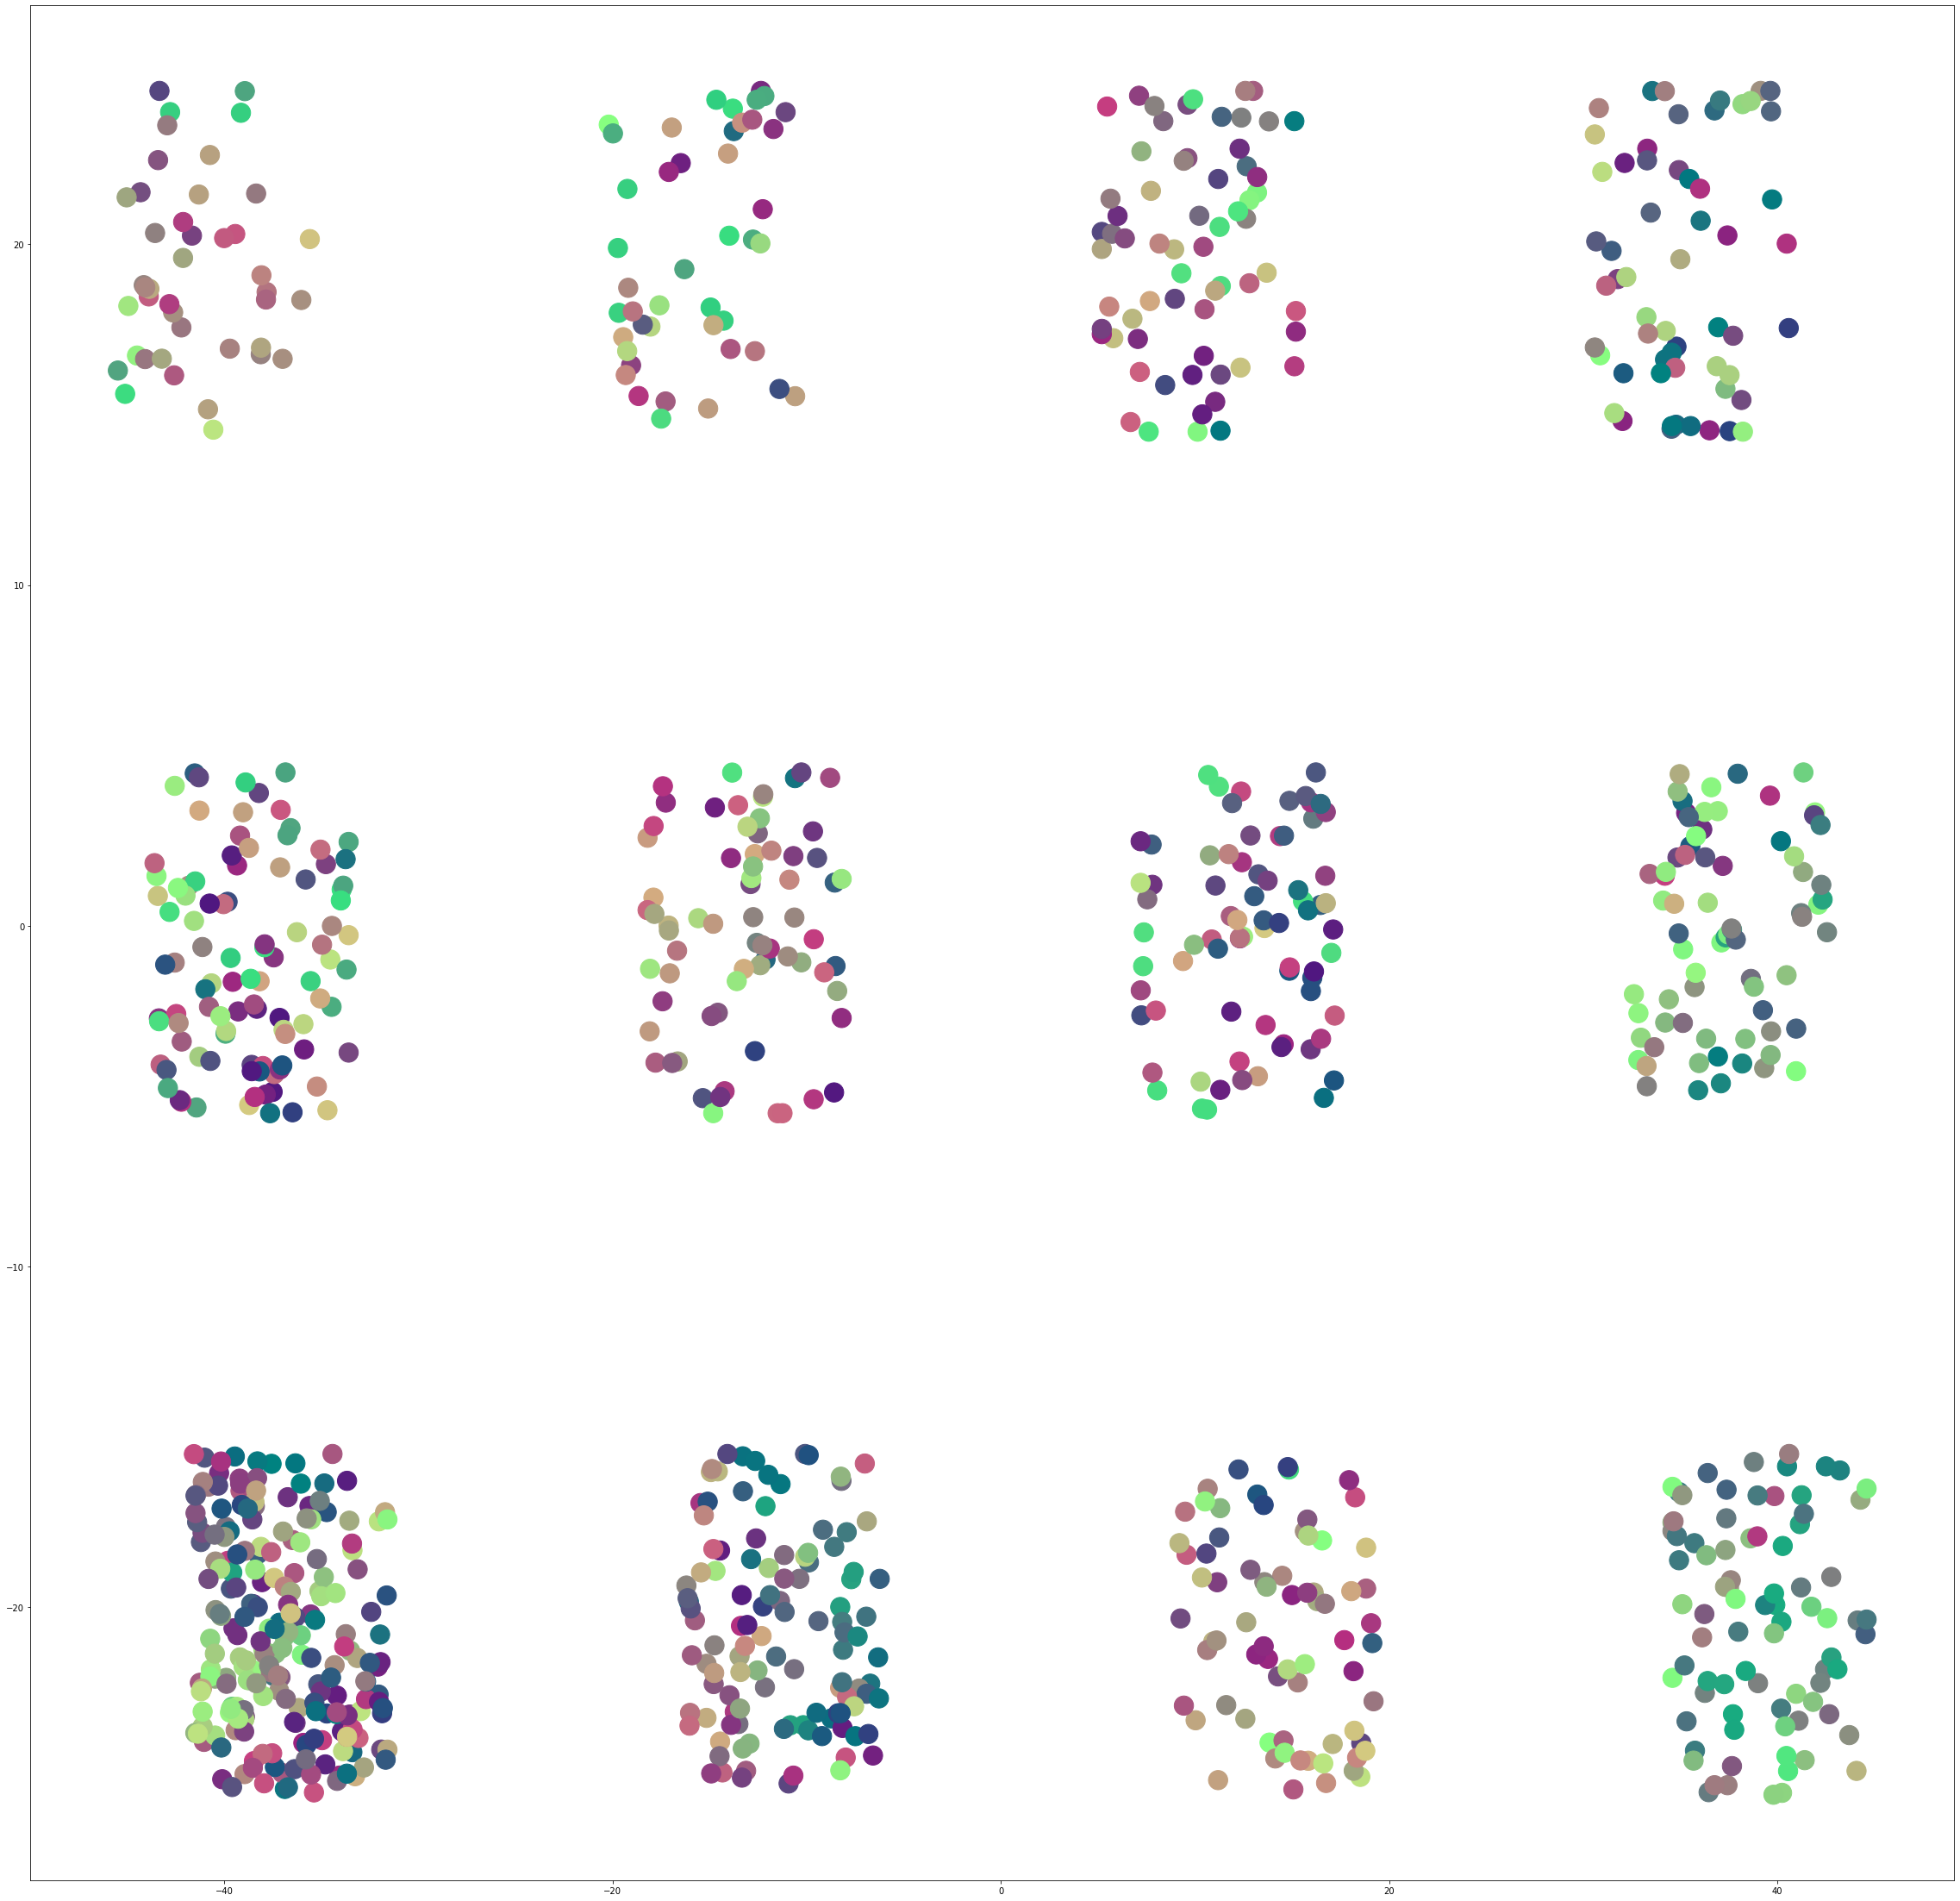

In [30]:
scattered_heatmap = plot_heatmap(X_embedded, xs, ys)

In [32]:
print(X_embedded.shape)
print(dataset[62608])
print(dataset.class_to_idx)
# print(view_indices)

(1000, 2)
(tensor([[[-0.9216, -0.9059, -0.9294,  ..., -0.9529, -0.9529, -0.9373],
         [-0.9216, -0.9216, -0.9451,  ..., -0.9529, -0.9451, -0.9294],
         [-0.9059, -0.9373, -0.9608,  ..., -0.9451, -0.9294, -0.9373],
         ...,
         [-0.9608, -0.9765, -0.9765,  ..., -0.9765, -0.9686, -0.9529],
         [-0.9686, -0.9765, -0.9686,  ..., -0.9608, -0.9529, -0.9529],
         [-0.9765, -0.9765, -0.9686,  ..., -0.9608, -0.9529, -0.9529]]]), 14)
{'MIA_L0001': 0, 'MIA_L0002': 1, 'MIA_L0003': 2, 'MIA_L0200': 3, 'MIA_L0201': 4, 'MIA_L0202': 5, 'MIA_L0203': 6, 'MIA_L0204': 7, 'MIA_L0205': 8, 'MIA_L0206': 9, 'MIA_L0207': 10, 'MIA_L0208': 11, 'MIA_L0209': 12, 'MIA_L0210': 13, 'MIA_L0211': 14}


# Create XYPT json metadata (don't run if already done)

In [2]:
# create metadata as json
def get_layer_xys(layer, dataset):
    '''
    returns a pd dataframe containing all rows whos trigger is 2.0 '''
    chunk_list =[]
    csv_filename = 'T500_3D_Scan_Strategies_fused_layer'+layer+'.csv'
    for chunk in pd.read_csv(XYPT_PATH+csv_filename, header=None,usecols=[0,1,3],chunksize=10000):
        chunk_list.append(chunk[chunk[3] == 2])

    final_df = pd.concat(chunk_list).reset_index(drop=True)
    final_df.columns = 'x','y','trigger'
    return final_df[['x','y']]
#     d[0].update({'path':image_path})

def get_layer(image_indx,dataset):
    '''
    returns the layer number e.g. 0001, 0211,... given image index in dataset
    '''
    _, layer_indx = dataset[image_indx]
    for k,v in dataset.class_to_idx.items():
        if v == layer_indx: 
            layer_name = k
            break
    return layer_name[len('MIA_L'):]

def get_xy(layer, dataset): 
    '''
    Given an image index (0 to 62608), return a dictionary of {'x': (some float), 'y': (some float)}
    '''
#     image_path = dataset.imgs[image_indx][0]
#     frame_id = os.path.basename(image_path)[len('frame'):]
#     frame_id = int(os.path.splitext(frame_id)[0])
#     layer = get_layer(image_indx, dataset)
    
    
    # get xy 
    # triggers is a PD dataframe of # image as num_rows and x,y,trigger as columns
    return extract_trigger_rows(XYPT_path + csv_filename)
    
XYPT_PATH = '../../../../../../Volumes/BackUp/Build Command Data/Build Command Data/XYPT Commands/'

xypt_data = []
layer = 1
for i in tqdm(range(len(dataset))):
    next_layer = get_layer(i,dataset)
    if int(next_layer) != 1:
        if next_layer != layer:
            # get new layer xy dataframe 
            layer = next_layer
            df = get_layer_xys(layer,dataset)
        # somehow layer 1 doesn't have XPYT file - we have to omit it manually
        image_path = dataset.imgs[i][0]
        frame_id = os.path.basename(image_path)[len('frame'):]
        frame_id = int(os.path.splitext(frame_id)[0])
        xy_dict = df.iloc[int(frame_id)-1].to_dict()
        xy_dict.update({'path':image_path})
        xypt_data.append(xy_dict)

print(len(xypt_data))
with open('xypt.json', 'w+') as outfile:
    json.dump(xypt_data, outfile)

NameError: name 'dataset' is not defined

### MNIST

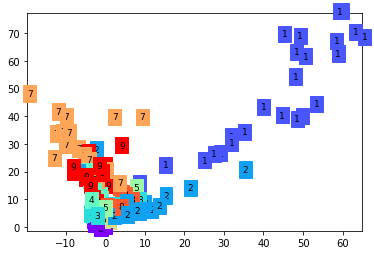

In [121]:
num_viewed = 200
view_indices = list(range(len(dataset)))
# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 28*28)
digits = np.random.randint(1, size=num_viewed)

for i in range(num_viewed):
    view_data[i,:] = dataset[view_indices[i]][0].view(-1,28*28)
    digits[i] = dataset[view_indices[i]][1]
    
encoded_data, _ = model(view_data)
plot2D_with_labels(encoded_data.data, digits)

# # alternate way to do the above
# view_data = dataset.data[:200].view(-1, 28*28).type(torch.FloatTensor)/255. # flatten each image to vector then normalize so max is max 1. 
# encoded_data, _ = model(view_data)

# digits = dataset.targets[:200].numpy()
# # view encoder output in 2D
# plot2D_with_labels(encoded_data.data, digits)

#### View encoder output using T-SNE

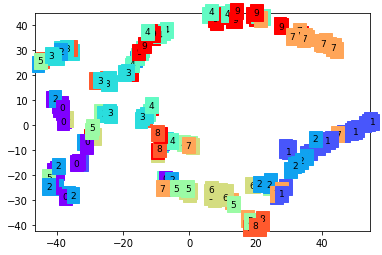

In [44]:
X = encoded_data.data.numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, digits)